# Notebook for testing Adaptive Approximate Metropolis-Hastings

In [76]:
%run _init_notebook.ipynb
from approxmh.vae import VAE
from approxmh.distributions import create_serpentine, IndependentMultivariateNormal
from approxmh.samplers import AdaptiveVAESampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


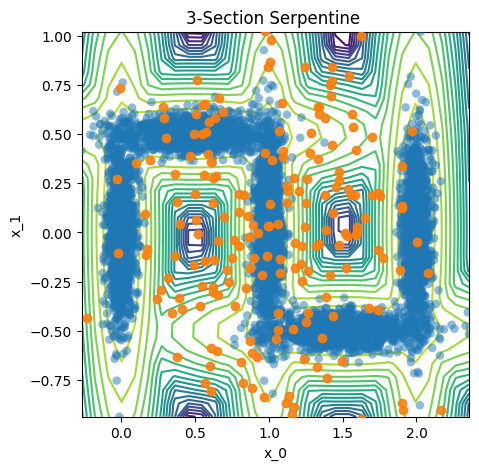

In [138]:
target = create_serpentine(n_sections=3, section_height=1, section_width=1, device=device)
# target = IndependentMultivariateNormal(mean=torch.tensor([0., -5.]), std=torch.tensor(0.1))
initial_sample = torch.distributions.Normal(loc=torch.tensor([1.0, 0.0]), scale=0.5).sample((200,))
visualize_distribution(target, sample_size=6_000, levels=20, plot_samples=True)
plt.gca().scatter(*pl(initial_sample), zorder=4, alpha=0.9)

In [139]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(4, 4, 4, 4, 4),
    latent_dim=target.dim,
    device=device
)
vae_ml_estimator = IWLikelihoodEstimator(
    model=vae,
    L=64,
#    time_step=0.8,
#    precondition=True
)

In [140]:
adaptive_sampler = AdaptiveVAESampler(
    target=target,
    model=vae,
    model_log_prob=vae_ml_estimator,
    initial_sample=initial_sample,
    device=device
)

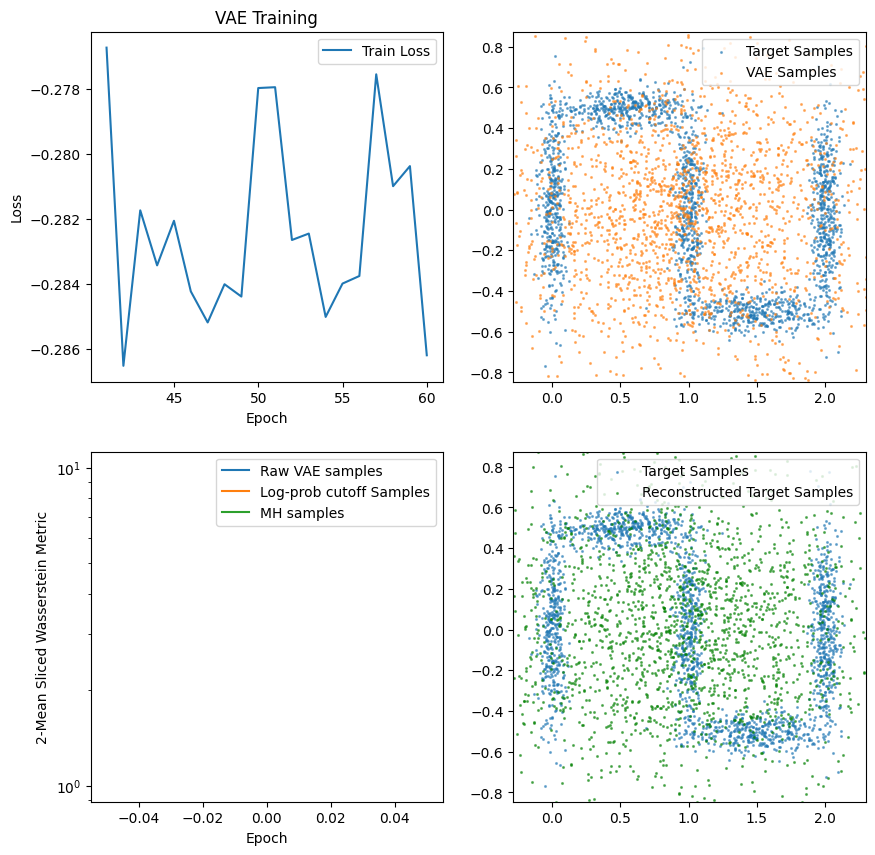

Epoch 60
	Train loss: -0.2862
	Validation loss: -0.3132
	Learning rate: 0.05


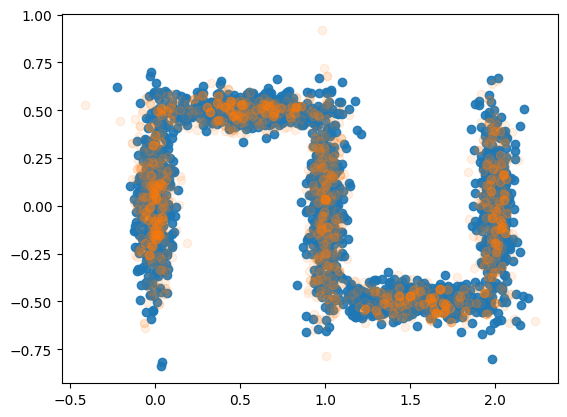

In [142]:
def retrain_and_sample():
    adaptive_sampler.retrain(
        optimizer='adam',
        lr=5e-2,
        n_epochs=60,
        kl_annealing_epochs=10,
        plot_interval=20,
        clear_sample_history=True
    )

    n_samples = 2000
    corrected_samples = adaptive_sampler.sample(n_samples)
    
    fig, ax = plt.subplots()
    ax.scatter(*pl(target.sample((n_samples,))), alpha=0.9)
    ax.scatter(*pl(corrected_samples), alpha=0.1)

retrain_and_sample()

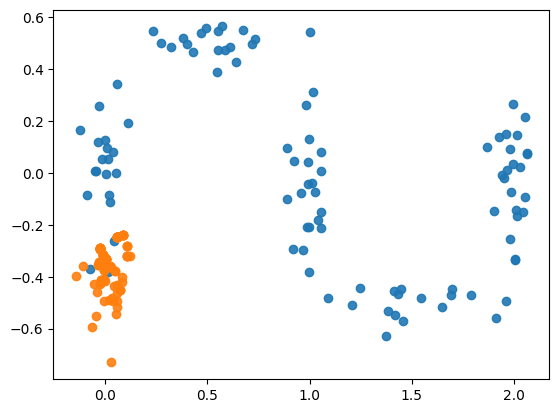